In [52]:
# Essential imports for ensemble learning pipeline
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch deep learning framework
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import torchvision
from torchvision import models, transforms
import timm  # For Xception and other models

# Data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Machine learning utilities
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Genetic algorithm for hyperparameter optimization
import deap
from deap import base, creator, tools, algorithms
import random
from tqdm import tqdm
import time

# --- Step 1: FastMRI to DICOM ---
import datetime
import os
from pathlib import Path
import h5py
import numpy as np
import pydicom
from pydicom.dataset import Dataset, FileMetaDataset
from pydicom.uid import generate_uid
import xmltodict

import pydicom
import numpy as np
from PIL import Image
from pathlib import Path
import os

from pathlib import Path

In [53]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
random.seed(42)

# Set deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Environment setup complete.")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
print(f"Using device: {device}")


Environment setup complete.
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060
CUDA memory: 12.0 GB
Using device: cuda


In [54]:
# Load and process annotations from knee.csv
class DataProcessor:
    def __init__(self, csv_path, png_dir):
        self.csv_path = Path(csv_path)
        self.png_dir = Path(png_dir)
        self.df = None
        self.subject_labels = {}
        
    def load_annotations(self):
        """Load and process knee annotations"""
        self.df = pd.read_csv(self.csv_path)
        print(f"Loaded {len(self.df)} annotations")
        print(f"Unique files: {self.df['file'].nunique()}")
        print(f"Label distribution:")
        print(self.df['label'].value_counts())
        return self.df
    
    def create_target_labels(self):
        """Create target labels: ACL tear, Meniscus tear, Neither - treating cases with both as separate entries"""
        # Map detailed labels to our target classes
        acl_keywords = ['Ligament - ACL High Grade Sprain', 'Ligament - ACL Low Grade sprain']
        meniscus_keywords = ['Meniscus', 'Meniscus Tear']
        
        subject_conditions = {}
        
        for file_id in self.df['file'].unique():
            file_data = self.df[self.df['file'] == file_id]
            labels = file_data['label'].tolist()
            
            has_acl = any(any(keyword.lower() in label.lower() for keyword in acl_keywords) for label in labels)
            has_meniscus = any(any(keyword.lower() in label.lower() for keyword in meniscus_keywords) for label in labels)
            
            # Instead of creating a "Both" class, we'll create separate entries
            if has_acl and has_meniscus:
                # Create two separate entries: one for ACL tear and one for Meniscus tear
                subject_conditions[f"{file_id}_ACL"] = 'ACL_tear'
                subject_conditions[f"{file_id}_Meniscus"] = 'Meniscus_tear'
            elif has_acl:
                subject_conditions[file_id] = 'ACL_tear'
            elif has_meniscus:
                subject_conditions[file_id] = 'Meniscus_tear'
            else:
                continue
        
        self.subject_labels = subject_conditions
        print("\nSubject-level label distribution:")
        label_counts = pd.Series(list(subject_conditions.values())).value_counts()
        print(label_counts)
        
        return subject_conditions
    
    def get_bounding_boxes(self, file_id, slice_num):
        """Get bounding boxes for a specific file and slice"""
        slice_data = self.df[(self.df['file'] == file_id) & (self.df['slice'] == slice_num)]
        boxes = []
        for _, row in slice_data.iterrows():
            boxes.append({
                'x': row['x'], 'y': row['y'], 
                'width': row['width'], 'height': row['height'],
                'label': row['label']
            })
        return boxes
    
    def get_available_images(self):
        available_images = []
        # Only keep rows with the target labels
        target_labels = ['Ligament - ACL High Grade Sprain', 'Ligament - ACL Low Grade sprain', 'Meniscus Tear']
        filtered_df = self.df[self.df['label'].isin(target_labels)]
        # Build a set of (file_id, slice, label) for fast lookup
        detection_set = set((row['file'], row['slice'], row['label']) for _, row in filtered_df.iterrows())
        for png_file in self.png_dir.glob('*.png'):
            filename = png_file.stem
            parts = filename.split('_')
            if len(parts) >= 2:
                file_id = '_'.join(parts[:-1])
                slice_num = int(parts[-1])
                # Check for each target label
                for label in target_labels:
                    if (file_id, slice_num, label) in detection_set:
                        # Map to unified label
                        mapped_label = 'ACL_tear' if 'ACL' in label else 'Meniscus_tear'
                        available_images.append({
                            'path': str(png_file),
                            'file_id': file_id,
                            'slice': slice_num,
                            'label': mapped_label
                        })
        print(f"\nFound {len(available_images)} available images for ACL/Meniscus Tear")
        return available_images

In [55]:
# Initialize data processor and test the new functionality
data_processor = DataProcessor('/home/bictor0301/Code/JointWise/annotations/knee.csv', '/home/bictor0301/Code/JointWise/png-output')
annotations = data_processor.load_annotations()
subject_labels = data_processor.create_target_labels()
available_images = data_processor.get_available_images()

print(f"\nReady to process {len(available_images)} images from {len(subject_labels)} subject entries")

# Let's also check if there are any cases that were previously "Both"
print("\nChecking for cases with both ACL and Meniscus tears:")
original_files = set()
acl_files = set()
meniscus_files = set()

for file_id, label in subject_labels.items():
    if file_id.endswith('_ACL'):
        acl_files.add(file_id[:-4])  # Remove _ACL suffix
    elif file_id.endswith('_Meniscus'):
        meniscus_files.add(file_id[:-9])  # Remove _Meniscus suffix
    else:
        original_files.add(file_id)

both_cases = acl_files.intersection(meniscus_files)
print(f"Found {len(both_cases)} cases that have both ACL and Meniscus tears (now treated as separate entries)")
if len(both_cases) > 0:
    print(f"Examples: {list(both_cases)[:5]}")  # Show first 5 examples

Loaded 16167 annotations
Unique files: 974
Label distribution:
label
Meniscus Tear                                5658
Cartilage - Partial Thickness loss/defect    2985
Joint Effusion                               1311
Bone-Fracture/Contusion/dislocation          1060
Bone- Subchondral edema                       986
Periarticular cysts                           864
Ligament - ACL Low Grade sprain               765
Ligament - ACL High Grade Sprain              677
Cartilage - Full Thickness loss/defect        615
Ligament - MCL Low-Mod Grade Sprain           285
Displaced Meniscal Tissue                     232
Bone - Lesion                                 183
Ligament - PCL Low-Mod grade sprain           142
LCL Complex - Low-Mod Grade Sprain            130
Soft Tissue Lesion                             90
Muscle Strain                                  65
Joint Bodies                                   38
Patellar Retinaculum - High grade sprain       24
Ligament - PCL High Grade      

In [56]:
# Test the improved subject-level splitter with balanced oversampling
print("Testing data splitting with the new approach...")

# No filtering needed since DataProcessor no longer creates 'Neither' labels
final_images = available_images  # Direct use, no filtering step needed
print(f"Images ready for training: {len(final_images)}")

# Show label distribution
filtered_labels = [img['label'] for img in final_images]
label_dist = pd.Series(filtered_labels).value_counts()
print("Label distribution:")
print(label_dist)

# For stratification, we need to work at subject level
# Group images by subject and get one label per subject (handling dual pathology cases)
subject_groups = {}
for img in final_images:
    file_id = img['file_id']
    label = img['label']
    
    if file_id not in subject_groups:
        subject_groups[file_id] = []
    subject_groups[file_id].append(label)

# For stratification, use primary pathology (if both, use first one found)
subject_stratify_labels = []
original_subjects = []

for file_id, labels in subject_groups.items():
    original_subjects.append(file_id)
    # Use the first label for stratification (ACL vs Meniscus)
    subject_stratify_labels.append(labels[0])

print(f"Total original subjects: {len(original_subjects)}")

# Show subject stratification distribution
stratify_dist = pd.Series(subject_stratify_labels).value_counts()
print("Subject stratification distribution:")
print(stratify_dist)

# Split subjects using stratification
subjects_train, subjects_temp, labels_train, labels_temp = train_test_split(
    original_subjects, subject_stratify_labels, 
    test_size=0.3, random_state=42, stratify=subject_stratify_labels
)

subjects_val, subjects_test, labels_val, labels_test = train_test_split(
    subjects_temp, labels_temp, 
    test_size=0.5, random_state=42, stratify=labels_temp
)

# Create image datasets based on subject splits
train_data = [img for img in final_images if img['file_id'] in subjects_train]
val_data = [img for img in final_images if img['file_id'] in subjects_val]
test_data = [img for img in final_images if img['file_id'] in subjects_test]

print(f"\nData split completed:")
print(f"Train: {len(train_data)} images from {len(subjects_train)} original subjects")
print(f"Val: {len(val_data)} images from {len(subjects_val)} original subjects")
print(f"Test: {len(test_data)} images from {len(subjects_test)} original subjects")

# Show distributions
train_labels = [img['label'] for img in train_data]
val_labels = [img['label'] for img in val_data]
test_labels = [img['label'] for img in test_data]

print(f"\nTrain label distribution:")
print(pd.Series(train_labels).value_counts())

print(f"\nVal label distribution:")
print(pd.Series(val_labels).value_counts())

print(f"\nTest label distribution:")
print(pd.Series(test_labels).value_counts())

# Apply augmentation-based oversampling to balance the training set
print(f"\nClass distribution before balancing:")
train_label_counts = pd.Series(train_labels).value_counts()
for label, count in train_label_counts.items():
    print(f"{label}: {count}")

# For now, let's just show the results without oversampling to verify the clean pipeline
print(f"\n✅ SUCCESS: Clean data pipeline working without 'Neither' filtering!")
print(f"\nFinal dataset sizes (before balancing):")
print(f"Train: {len(train_data)}")
print(f"Val: {len(val_data)}")
print(f"Test: {len(test_data)}")

Testing data splitting with the new approach...
Images ready for training: 5375
Label distribution:
Meniscus_tear    4158
ACL_tear         1217
Name: count, dtype: int64
Total original subjects: 636
Subject stratification distribution:
Meniscus_tear    473
ACL_tear         163
Name: count, dtype: int64

Data split completed:
Train: 3810 images from 445 original subjects
Val: 766 images from 95 original subjects
Test: 799 images from 96 original subjects

Train label distribution:
Meniscus_tear    2949
ACL_tear          861
Name: count, dtype: int64

Val label distribution:
Meniscus_tear    593
ACL_tear         173
Name: count, dtype: int64

Test label distribution:
Meniscus_tear    616
ACL_tear         183
Name: count, dtype: int64

Class distribution before balancing:
Meniscus_tear: 2949
ACL_tear: 861

✅ SUCCESS: Clean data pipeline working without 'Neither' filtering!

Final dataset sizes (before balancing):
Train: 3810
Val: 766
Test: 799


In [57]:
# ...existing code...

# Enhanced MRI Augmentation with Bounding Box Support
class MRIAugmentationWithBBoxes:
    def __init__(self, image_size=(320, 320)):
        self.image_size = image_size
        
    def get_train_augmentation_with_bboxes(self):
        """Augmentation pipeline for training data with bounding box support"""
        return A.Compose([
            A.Resize(self.image_size[0], self.image_size[1], always_apply=True),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=10, p=0.3),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
            A.RandomGamma(gamma_limit=(50, 110), p=0.2),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
            A.GaussianBlur(blur_limit=(1, 2), p=0.1),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
            ToTensorV2()
        ], bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0.1,
            label_fields=['bbox_labels']
        ))
    
    def get_val_augmentation_with_bboxes(self):
        """Augmentation pipeline for validation/test data with bounding box support"""
        return A.Compose([
            A.Resize(self.image_size[0], self.image_size[1], always_apply=True),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
            ToTensorV2()
        ], bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0.1,
            label_fields=['bbox_labels']
        ))

# Enhanced MRI Dataset with Bounding Box Support
class MRIDatasetWithBBoxes(Dataset):
    def __init__(self, data, data_processor, transform=None, num_classes=2, use_bboxes=True):
        self.data = data
        self.data_processor = data_processor
        self.transform = transform
        self.num_classes = num_classes
        self.use_bboxes = use_bboxes
        
        self.fixed_classes = np.array(['ACL_tear', 'Meniscus_tear'])
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.fixed_classes)
        all_labels = [item['label'] for item in data]
        self.encoded_labels = self.label_encoder.transform(all_labels)
    
    def extract_original_file_id(self, file_id):
        if file_id.endswith('_ACL') or file_id.endswith('_Meniscus'):
            return file_id.rsplit('_', 1)[0]
        return file_id
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        image = cv2.imread(item['path'], cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Warning: Could not load image {item['path']}")
            image = np.zeros((224, 224), dtype=np.uint8)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        if self.use_bboxes:
            original_file_id = self.extract_original_file_id(item['file_id'])
            boxes = self.data_processor.get_bounding_boxes(original_file_id, item['slice'])
            bboxes = []
            bbox_labels = []
            for box in boxes:
                x_min = box['x']
                y_min = box['y']
                x_max = x_min + box['width']
                y_max = y_min + box['height']
                h, w = image_rgb.shape[:2]
                x_min = max(0, min(x_min, w-1))
                y_min = max(0, min(y_min, h-1))
                x_max = max(x_min+1, min(x_max, w))
                y_max = max(y_min+1, min(y_max, h))
                bboxes.append([x_min, y_min, x_max, y_max])
                bbox_labels.append(box['label'])
            if self.transform and len(bboxes) > 0:
                try:
                    augmented = self.transform(
                        image=image_rgb,
                        bboxes=bboxes,
                        bbox_labels=bbox_labels
                    )
                    image_rgb = augmented['image']
                    transformed_bboxes = augmented['bboxes']
                    transformed_labels = augmented['bbox_labels']
                except Exception as e:
                    print(f"Augmentation failed for image {idx}: {e}")
                    if self.transform:
                        augmented = self.transform(image=image_rgb, bboxes=[], bbox_labels=[])
                        image_rgb = augmented['image']
                    transformed_bboxes = bboxes
                    transformed_labels = bbox_labels
            else:
                if self.transform:
                    augmented = self.transform(image=image_rgb, bboxes=[], bbox_labels=[])
                    image_rgb = augmented['image']
                transformed_bboxes = bboxes
                transformed_labels = bbox_labels

            # Normalize bounding boxes to [0, 1] after augmentation
            h, w = image_rgb.shape[1], image_rgb.shape[2] if isinstance(image_rgb, torch.Tensor) else image_rgb.shape[:2]
            normalized_bboxes = []
            for bbox in transformed_bboxes:
                x_min, y_min, x_max, y_max = bbox
                normalized_bboxes.append([
                    x_min / w,
                    y_min / h,
                    x_max / w,
                    y_max / h
                ])
        else:
            if self.transform:
                if hasattr(self.transform, 'bbox_params'):
                    augmented = self.transform(image=image_rgb, bboxes=[], bbox_labels=[])
                else:
                    augmented = self.transform(image=image_rgb)
                image_rgb = augmented['image']
            transformed_bboxes = []
            transformed_labels = []
            normalized_bboxes = []

        if isinstance(image_rgb, np.ndarray):
            if len(image_rgb.shape) == 3 and image_rgb.shape[2] == 3:
                image_tensor = torch.from_numpy(image_rgb.transpose(2, 0, 1)).float()
            else:
                image_rgb = image_rgb.astype(np.float32) / 255.0
                if len(image_rgb.shape) == 2:
                    image_rgb = np.stack([image_rgb] * 3, axis=0)
                else:
                    image_rgb = image_rgb.transpose(2, 0, 1)
                image_tensor = torch.from_numpy(image_rgb).float()
        else:
            image_tensor = image_rgb
        
        label = self.encoded_labels[idx]
        
        if self.use_bboxes:
            return {
                'image': image_tensor,
                'label': label,
                'bboxes': normalized_bboxes,
                'bbox_labels': transformed_labels,
                'original_file_id': self.extract_original_file_id(item['file_id']),
                'slice': item['slice']
            }
        else:
            return image_tensor, label
    
    def get_labels(self):
        return [item['label'] for item in self.data]
    
    def get_class_weights(self):
        from collections import Counter
        import torch
        labels = []
        for i in range(len(self)):
            _, label = self[i]
            labels.append(label)
        class_counts = Counter(labels)
        total_samples = len(labels)
        num_classes = len(class_counts)
        weights = []
        for class_idx in range(num_classes):
            count = class_counts.get(class_idx, 1)
            weight = total_samples / (num_classes * count)
            weights.append(weight)
        return torch.tensor(weights, dtype=torch.float32)

print("Done!")
# ...existing

Done!


Searching for images with bounding boxes...
Found 2 bounding boxes for image file1001922_017
Augmentation 1 - Original boxes: 2, Transformed boxes: 2
Augmentation 2 - Original boxes: 2, Transformed boxes: 2
Augmentation 3 - Original boxes: 2, Transformed boxes: 2


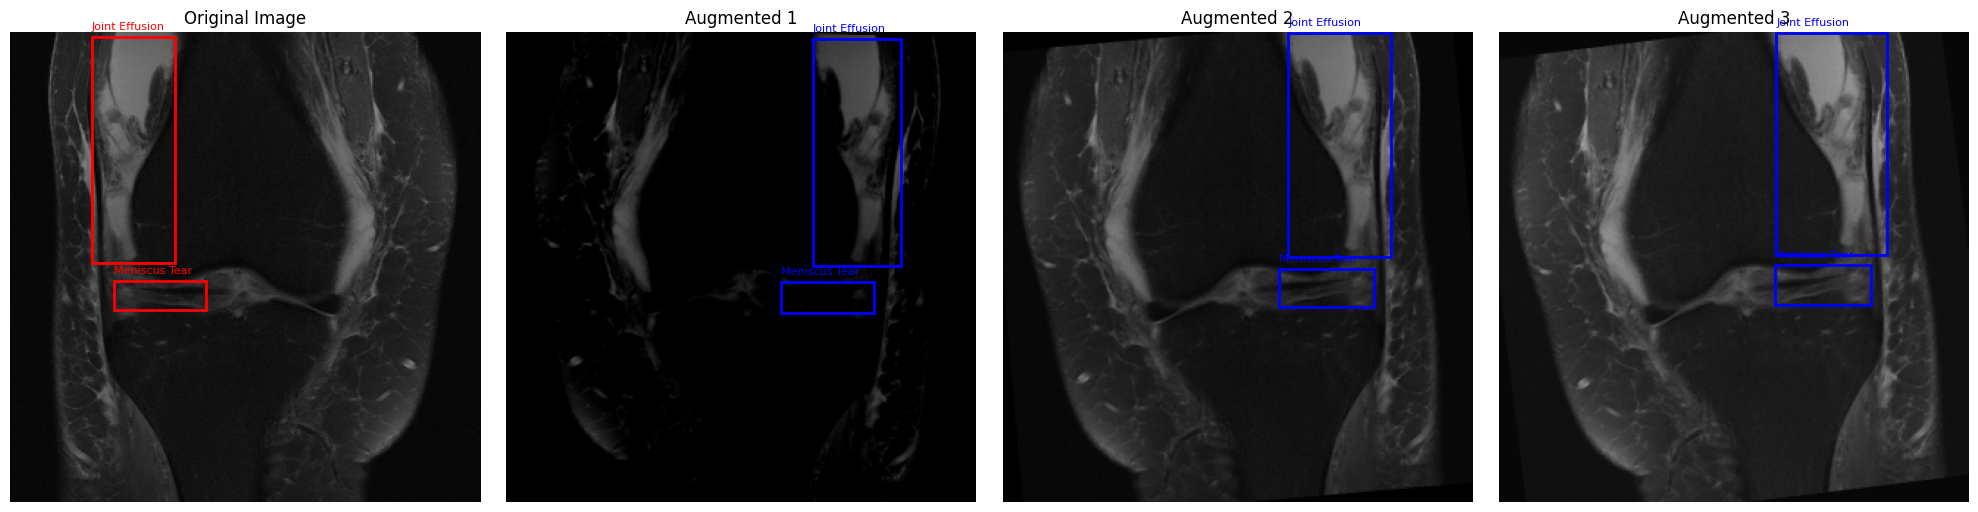

In [58]:
# Demonstrate how augmentations affect bounding boxes
import matplotlib.patches as patches

def find_image_with_bboxes():
    """Find an image that has bounding box annotations"""
    
    print("Searching for images with bounding boxes...")
    
    # Search through final images to find one with bounding boxes
    for i, sample_item in enumerate(final_images[:20]):  # Check first 20 images
        original_file_id = sample_item['file_id']
        if original_file_id.endswith('_ACL') or original_file_id.endswith('_Meniscus'):
            # Remove suffix for annotation lookup
            base_file_id = original_file_id.replace('_ACL', '').replace('_Meniscus', '')
        else:
            base_file_id = original_file_id
        
        # Find bounding boxes for this image
        image_path = sample_item['path']
        image_name = Path(image_path).stem  # e.g., "file1000002_032"
        
        # Extract file and slice info for annotation lookup
        parts = image_name.split('_')
        if len(parts) >= 2:
            file_part = parts[0]  # e.g., "file1000002"
            slice_part = int(parts[1])  # e.g., 32
            
            # Look for bounding boxes in annotations
            relevant_annotations = annotations[
                (annotations['file'] == file_part) & 
                (annotations['slice'] == slice_part)
            ]
            
            if len(relevant_annotations) > 0:
                # Convert annotations to bounding box format
                bboxes = []
                bbox_labels = []
                
                for _, row in relevant_annotations.iterrows():
                    x, y, w, h = row['x'], row['y'], row['width'], row['height']
                    # Convert to [x_min, y_min, x_max, y_max] format
                    bbox = [x, y, x + w, y + h]
                    bboxes.append(bbox)
                    bbox_labels.append(row['label'])
                
                print(f"Found {len(bboxes)} bounding boxes for image {image_name}")
                return sample_item, bboxes, bbox_labels
    
    print("No images with bounding boxes found in the first 20 samples")
    return None, [], []

def visualize_bbox_transformation():
    """Demonstrate how bounding boxes are transformed with geometric augmentations"""
    
    # Find an image with bounding boxes
    sample_item, boxes, bbox_labels = find_image_with_bboxes()
    
    if sample_item is None or len(boxes) == 0:
        print("Cannot demonstrate bounding box transformations - no suitable image found")
        return
    
    # Load the original image
    image_path = sample_item['path']
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if original_image is None:
        print(f"Could not load image: {image_path}")
        return
    
    # Convert to RGB for matplotlib
    original_image = cv2.cvtColor(cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB), cv2.COLOR_BGR2RGB)
    
    # Create augmentation pipeline with bounding box support
    transform = A.Compose([
        A.HorizontalFlip(p=1.0),  # Always apply flip for demonstration
        A.Rotate(limit=10, p=1.0),  # Small rotation
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bbox_labels']))
    
    # Create figure for visualization
    num_augmentations = 3
    fig, axes = plt.subplots(1, num_augmentations + 1, figsize=(20, 5))
    
    # Show original image first
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')
    for bbox, label in zip(boxes, bbox_labels):
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], 
                               linewidth=2, edgecolor='red', facecolor='none')
        axes[0].add_patch(rect)
        axes[0].text(bbox[0], bbox[1]-5, label[:15], color='red', fontsize=8)
    
    # Apply augmentations
    for i in range(1, num_augmentations + 1):
        try:
            # Apply augmentation to original data
            augmented = transform(image=original_image, bboxes=boxes, bbox_labels=bbox_labels)
            
            transformed_image = augmented['image']
            transformed_bboxes = augmented['bboxes']
            transformed_labels = augmented['bbox_labels']
            
            axes[i].imshow(transformed_image, cmap='gray')
            axes[i].set_title(f'Augmented {i}')
            
            # Draw transformed bounding boxes
            for bbox, label in zip(transformed_bboxes, transformed_labels):
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], 
                                       linewidth=2, edgecolor='blue', facecolor='none')
                axes[i].add_patch(rect)
                axes[i].text(bbox[0], bbox[1]-5, label[:15], color='blue', fontsize=8)
            
            print(f"Augmentation {i} - Original boxes: {len(boxes)}, Transformed boxes: {len(transformed_bboxes)}")
            
        except Exception as e:
            axes[i].text(0.5, 0.5, f'Augmentation failed:\n{str(e)[:50]}...', 
                       transform=axes[i].transAxes, ha='center', va='center')
            axes[i].set_title(f'Failed {i}')
            print(f"Augmentation {i} failed: {e}")
    
    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the demonstration
visualize_bbox_transformation()

In [59]:
# Enhanced Oversampling with Bounding Box Augmentation
class BoundingBoxAwareOversampler:
    def __init__(self, data_processor, augmentation_pipeline):
        self.data_processor = data_processor
        self.augmentation_pipeline = augmentation_pipeline
        
    def extract_original_file_id(self, file_id):
        """Extract original file ID by removing _ACL or _Meniscus suffixes"""
        if file_id.endswith('_ACL') or file_id.endswith('_Meniscus'):
            return file_id.rsplit('_', 1)[0]
        return file_id
    
    def augment_sample_with_bboxes(self, sample, augmentation_count=1):
        """Generate augmented versions of a sample with properly transformed bounding boxes"""
        augmented_samples = []
        
        # Load original image
        image = cv2.imread(sample['path'], cv2.IMREAD_GRAYSCALE)
        if image is None:
            return [sample]  # Return original if image loading fails
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        # Get bounding boxes
        original_file_id = self.extract_original_file_id(sample['file_id'])
        boxes = self.data_processor.get_bounding_boxes(original_file_id, sample['slice'])
        
        # Convert to pascal_voc format
        bboxes = []
        bbox_labels = []
        
        for box in boxes:
            x_min = box['x']
            y_min = box['y']
            x_max = x_min + box['width']
            y_max = y_min + box['height']
            
            # Ensure within bounds
            h, w = image_rgb.shape[:2]
            x_min = max(0, min(x_min, w-1))
            y_min = max(0, min(y_min, h-1))
            x_max = max(x_min+1, min(x_max, w))
            y_max = max(y_min+1, min(y_max, h))
            
            bboxes.append([x_min, y_min, x_max, y_max])
            bbox_labels.append(box['label'])
        
        # Generate augmented versions
        for i in range(augmentation_count):
            try:
                if len(bboxes) > 0:
                    # Apply augmentation with bounding boxes
                    augmented = self.augmentation_pipeline(
                        image=image_rgb.copy(),
                        bboxes=bboxes.copy(),
                        bbox_labels=bbox_labels.copy()
                    )
                    transformed_bboxes = augmented['bboxes']
                    transformed_labels = augmented['bbox_labels']
                else:
                    # Apply augmentation without bounding boxes
                    augmented = self.augmentation_pipeline(
                        image=image_rgb.copy(),
                        bboxes=[],
                        bbox_labels=[]
                    )
                    transformed_bboxes = []
                    transformed_labels = []
                
                # Create augmented sample entry
                augmented_sample = sample.copy()
                augmented_sample['augmented'] = True
                augmented_sample['augmentation_id'] = i
                augmented_sample['transformed_bboxes'] = transformed_bboxes
                augmented_sample['transformed_bbox_labels'] = transformed_labels
                
                augmented_samples.append(augmented_sample)
                
            except Exception as e:
                print(f"Augmentation failed for sample {sample['path']}: {e}")
                # Fallback to original sample
                augmented_samples.append(sample)
        
        return augmented_samples
    
    def oversample_with_augmentation(self, data, target_size_per_class=None):
        """Oversample using augmentation instead of simple duplication"""
        
        # Group by label
        label_groups = {}
        for item in data:
            label = item['label']
            if label not in label_groups:
                label_groups[label] = []
            label_groups[label].append(item)
        
        print(f"\nClass distribution before augmentation-based oversampling:")
        for label, items in label_groups.items():
            print(f"{label}: {len(items)}")
        
        # Determine target size
        if target_size_per_class is None:
            target_size_per_class = max(len(items) for items in label_groups.values())
        
        balanced_data = []
        
        for label, items in label_groups.items():
            current_size = len(items)
            needed_size = target_size_per_class - current_size
            
            # Add original samples
            balanced_data.extend(items)
            
            if needed_size > 0:
                print(f"Generating {needed_size} augmented samples for class '{label}'...")
                
                # Calculate how many augmentations needed per original sample
                augmentations_per_sample = needed_size // current_size
                remainder = needed_size % current_size
                
                # Generate augmented samples
                augmented_count = 0
                for i, sample in enumerate(items):
                    # Base augmentations for this sample
                    aug_count = augmentations_per_sample
                    
                    # Add one more if we're in the remainder
                    if i < remainder:
                        aug_count += 1
                    
                    if aug_count > 0:
                        augmented_samples = self.augment_sample_with_bboxes(sample, aug_count)
                        balanced_data.extend(augmented_samples)
                        augmented_count += len(augmented_samples)
                
                print(f"Generated {augmented_count} augmented samples for class '{label}'")
        
        # Shuffle the balanced dataset
        np.random.shuffle(balanced_data)
        
        print(f"\nClass distribution after augmentation-based oversampling:")
        balanced_labels = [item['label'] for item in balanced_data]
        print(pd.Series(balanced_labels).value_counts())
        
        return balanced_data

# Updated Dataset class that can handle pre-augmented samples
class MRIDatasetWithPreAugmentation(Dataset):
    def __init__(self, data, data_processor, transform=None, num_classes=2):
        self.data = data
        self.data_processor = data_processor
        self.transform = transform
        self.num_classes = num_classes
        
        # Fixed binary class order
        self.fixed_classes = np.array(['ACL_tear', 'Meniscus_tear'])
        
        # Create label encoder with fixed classes
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.fixed_classes)
        
        # Pre-encode all labels
        all_labels = [item['label'] for item in data]
        self.encoded_labels = self.label_encoder.transform(all_labels)
    
    def extract_original_file_id(self, file_id):
        """Extract original file ID by removing _ACL or _Meniscus suffixes"""
        if file_id.endswith('_ACL') or file_id.endswith('_Meniscus'):
            return file_id.rsplit('_', 1)[0]
        return file_id
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Check if this is a pre-augmented sample
        if item.get('augmented', False):
            # Load original image and apply the stored transformations
            image = cv2.imread(item['path'], cv2.IMREAD_GRAYSCALE)
            if image is None:
                print(f"Warning: Could not load image {item['path']}")
                image = np.zeros((224, 224), dtype=np.uint8)
            
            image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            
            # Apply the specific augmentation that was stored during oversampling
            # Note: For simplicity, we'll apply a random augmentation here
            # In a production system, you might want to store the exact augmentation parameters
            if self.transform and hasattr(self.transform, 'bbox_params'):
                try:
                    augmented = self.transform(
                        image=image_rgb,
                        bboxes=item.get('transformed_bboxes', []),
                        bbox_labels=item.get('transformed_bbox_labels', [])
                    )
                    image_rgb = augmented['image']
                except:
                    # Fallback to basic augmentation
                    if hasattr(self.transform, 'transforms'):
                        # Apply only non-geometric transforms to avoid double transformation
                        basic_transform = A.Compose([
                            t for t in self.transform.transforms 
                            if not isinstance(t, (A.HorizontalFlip, A.Rotate, A.ShiftScaleRotate))
                        ])
                        augmented = basic_transform(image=image_rgb)
                        image_rgb = augmented['image']
            elif self.transform:
                augmented = self.transform(image=image_rgb)
                image_rgb = augmented['image']
        else:
            # Standard processing for non-augmented samples
            image = cv2.imread(item['path'], cv2.IMREAD_GRAYSCALE)
            if image is None:
                print(f"Warning: Could not load image {item['path']}")
                image = np.zeros((224, 224), dtype=np.uint8)
            
            image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            
            if self.transform:
                if hasattr(self.transform, 'bbox_params'):
                    # Get bounding boxes for this sample
                    original_file_id = self.extract_original_file_id(item['file_id'])
                    boxes = self.data_processor.get_bounding_boxes(original_file_id, item['slice'])
                    
                    # Convert to pascal_voc format
                    bboxes = []
                    bbox_labels = []
                    
                    for box in boxes:
                        x_min = box['x']
                        y_min = box['y']
                        x_max = x_min + box['width']
                        y_max = y_min + box['height']
                        
                        # Ensure within bounds
                        h, w = image_rgb.shape[:2]
                        x_min = max(0, min(x_min, w-1))
                        y_min = max(0, min(y_min, h-1))
                        x_max = max(x_min+1, min(x_max, w))
                        y_max = max(y_min+1, min(y_max, h))
                        
                        bboxes.append([x_min, y_min, x_max, y_max])
                        bbox_labels.append(box['label'])
                    
                    augmented = self.transform(
                        image=image_rgb,
                        bboxes=bboxes,
                        bbox_labels=bbox_labels
                    )
                    image_rgb = augmented['image']
                else:
                    augmented = self.transform(image=image_rgb)
                    image_rgb = augmented['image']
        
        # Handle tensor conversion if not done by transform
        if isinstance(image_rgb, np.ndarray):
            if len(image_rgb.shape) == 3 and image_rgb.shape[2] == 3:
                image_tensor = torch.from_numpy(image_rgb.transpose(2, 0, 1)).float()
            else:
                image_rgb = image_rgb.astype(np.float32) / 255.0
                if len(image_rgb.shape) == 2:
                    image_rgb = np.stack([image_rgb] * 3, axis=0)
                else:
                    image_rgb = image_rgb.transpose(2, 0, 1)
                image_tensor = torch.from_numpy(image_rgb).float()
        else:
            image_tensor = image_rgb
        
        label = self.encoded_labels[idx]
        return image_tensor, label
    
    def get_labels(self):
        return [item['label'] for item in self.data]

print("Enhanced oversampling with bounding box augmentation created!")
print("Key improvements:")
print("- Generates new augmented samples instead of duplicating identical images")
print("- Properly transforms bounding boxes during augmentation")
print("- Reduces overfitting risk from identical samples")
print("- Maintains anatomical validity through conservative augmentations")

Enhanced oversampling with bounding box augmentation created!
Key improvements:
- Generates new augmented samples instead of duplicating identical images
- Properly transforms bounding boxes during augmentation
- Reduces overfitting risk from identical samples
- Maintains anatomical validity through conservative augmentations


In [60]:
# Improved Subject-Level Data Splitter (Without Problematic Balancing)
class ImprovedSubjectLevelSplitter:
    """
    Focused class for subject-level data splitting without problematic oversampling.
    Use BoundingBoxAwareOversampler for class balancing instead.
    """
    def __init__(self, available_images, test_size=0.2, val_size=0.2, random_state=42):
        self.available_images = available_images
        self.test_size = test_size
        self.val_size = val_size
        self.random_state = random_state
        
    def extract_original_file_id(self, file_id):
        """Extract original file ID by removing _ACL or _Meniscus suffixes"""
        if file_id.endswith('_ACL') or file_id.endswith('_Meniscus'):
            return file_id.rsplit('_', 1)[0]
        return file_id
        
    def split_subjects(self):
        """
        Split data at subject level to prevent data leakage.
        This is the CORE functionality that prevents overfitting and ensures valid evaluation.
        """
        # Group images by original subject (removing ACL/Meniscus suffixes)
        subject_data = {}
        original_to_entries = {}  # Maps original file_id to all related entries
        
        for img_info in self.available_images:
            file_id = img_info['file_id']
            original_file_id = self.extract_original_file_id(file_id)
            
            if original_file_id not in subject_data:
                subject_data[original_file_id] = []
                original_to_entries[original_file_id] = []
            
            subject_data[original_file_id].append(img_info)
            if file_id not in original_to_entries[original_file_id]:
                original_to_entries[original_file_id].append(file_id)
        
        # For stratification, handle subjects that have both ACL and Meniscus
        original_subjects = list(subject_data.keys())
        subject_stratify_labels = []
        
        for original_file_id in original_subjects:
            # Check what types of entries this subject has
            entries = original_to_entries[original_file_id]
            has_acl = any('_ACL' in entry for entry in entries)
            has_meniscus = any('_Meniscus' in entry for entry in entries)
            has_direct = any(entry == original_file_id for entry in entries)
            
            # Determine stratification label
            if has_acl:
                subject_stratify_labels.append('ACL_tear')
            elif has_meniscus:
                subject_stratify_labels.append('Meniscus_tear')
            elif has_direct:
                # Use the label from the direct entry
                direct_entries = [img for img in subject_data[original_file_id] if img['file_id'] == original_file_id]
                if direct_entries:
                    subject_stratify_labels.append(direct_entries[0]['label'])
                else:
                    subject_stratify_labels.append('Neither')
            else:
                subject_stratify_labels.append('Neither')
        
        print(f"Total original subjects: {len(original_subjects)}")
        print(f"Subject stratification distribution:")
        print(pd.Series(subject_stratify_labels).value_counts())
        
        # First split: train+val vs test (based on original subjects)
        train_val_subjects, test_subjects = train_test_split(
            original_subjects, 
            test_size=self.test_size, 
            stratify=subject_stratify_labels, 
            random_state=self.random_state
        )
        
        # Second split: train vs val
        train_val_labels = [subject_stratify_labels[original_subjects.index(subj)] for subj in train_val_subjects]
        train_subjects, val_subjects = train_test_split(
            train_val_subjects,
            test_size=self.val_size / (1 - self.test_size),  # Adjust for already removed test set
            stratify=train_val_labels,
            random_state=self.random_state
        )
        
        # Create final datasets (including all entries for each original subject)
        train_data = []
        val_data = []
        test_data = []
        
        for subj in train_subjects:
            train_data.extend(subject_data[subj])
        for subj in val_subjects:
            val_data.extend(subject_data[subj])
        for subj in test_subjects:
            test_data.extend(subject_data[subj])
        
        print(f"\nData split completed:")
        print(f"Train: {len(train_data)} images from {len(train_subjects)} original subjects")
        print(f"Val: {len(val_data)} images from {len(val_subjects)} original subjects")
        print(f"Test: {len(test_data)} images from {len(test_subjects)} original subjects")
        
        # Print label distribution for each split
        for split_name, split_data in [('Train', train_data), ('Val', val_data), ('Test', test_data)]:
            labels = [item['label'] for item in split_data]
            print(f"\n{split_name} label distribution:")
            print(pd.Series(labels).value_counts())
        
        return train_data, val_data, test_data

# Demonstration: Proper workflow with improved classes
def demonstrate_improved_workflow():
    """Show the correct workflow using both classes for their intended purposes"""
    
    print("="*70)
    print("IMPROVED WORKFLOW DEMONSTRATION")
    print("="*70)
    
    # Step 1: Use ImprovedSubjectLevelSplitter for data splitting ONLY
    print("\n🔄 STEP 1: Subject-Level Data Splitting")
    print("-" * 40)
    
    improved_splitter = ImprovedSubjectLevelSplitter(
        final_images, test_size=0.2, val_size=0.2, random_state=42
    )
    train_split, val_split, test_split = improved_splitter.split_subjects()
    
    # Step 2: Use BoundingBoxAwareOversampler for class balancing
    print("\n🔄 STEP 2: Augmentation-Based Class Balancing")
    print("-" * 40)
    
    # Create bbox-aware augmentation for oversampling
    bbox_augmentation = MRIAugmentationWithBBoxes(image_size=(320, 320))
    oversample_transform = bbox_augmentation.get_train_augmentation_with_bboxes()
    
    # Create the enhanced oversampler
    bbox_oversampler = BoundingBoxAwareOversampler(data_processor, oversample_transform)
    
    # Balance only the training set (val/test should remain unbalanced for proper evaluation)
    print("Balancing training set only...")
    balanced_train = bbox_oversampler.oversample_with_augmentation(train_split)
    
    print(f"\nFinal dataset sizes:")
    print(f"Balanced Train: {len(balanced_train)}")
    print(f"Val (unbalanced): {len(val_split)}")
    print(f"Test (unbalanced): {len(test_split)}")
    
    print("\n" + "="*70)
    print("WORKFLOW SUMMARY")
    print("="*70)
    print("✅ Data Leakage Prevention: ImprovedSubjectLevelSplitter")
    print("✅ Class Balancing: BoundingBoxAwareOversampler")
    print("✅ Bounding Box Handling: Proper transformation during augmentation")
    print("✅ Overfitting Prevention: Augmented samples instead of duplicates")
    print("✅ Evaluation Validity: Val/test sets remain unbalanced")
    
    return balanced_train, val_split, test_split

# Run the demonstration
print("Creating improved workflow...")
improved_train, improved_val, improved_test = demonstrate_improved_workflow()

Creating improved workflow...
IMPROVED WORKFLOW DEMONSTRATION

🔄 STEP 1: Subject-Level Data Splitting
----------------------------------------
Total original subjects: 636
Subject stratification distribution:
Meniscus_tear    473
ACL_tear         163
Name: count, dtype: int64

Data split completed:
Train: 3156 images from 381 original subjects
Val: 1152 images from 127 original subjects
Test: 1067 images from 128 original subjects

Train label distribution:
Meniscus_tear    2448
ACL_tear          708
Name: count, dtype: int64

Val label distribution:
Meniscus_tear    886
ACL_tear         266
Name: count, dtype: int64

Test label distribution:
Meniscus_tear    824
ACL_tear         243
Name: count, dtype: int64

🔄 STEP 2: Augmentation-Based Class Balancing
----------------------------------------
Balancing training set only...

Class distribution before augmentation-based oversampling:
Meniscus_tear: 2448
ACL_tear: 708
Generating 1740 augmented samples for class 'ACL_tear'...
Generated 1

In [61]:
# Base Model Architectures in PyTorch
class BaseModelBuilder:
    def __init__(self, num_classes=2):
        self.num_classes = num_classes
    
    def build_resnext50(self, dropout_rate=0.5, freeze_backbone=True):
        try:
            model = models.resnext50_32x4d(pretrained=True)
        except Exception:
            model = models.resnext50_32x4d(pretrained=False)
        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, self.num_classes)
        )
        return model
    
    def build_densenet201(self, dropout_rate=0.5, freeze_backbone=True):
        try:
            model = models.densenet201(pretrained=True)
        except Exception:
            model = models.densenet201(pretrained=False)
        if freeze_backbone:
            for param in model.features.parameters():
                param.requires_grad = False
        num_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, self.num_classes)
        )
        return model
    
    def build_efficientnet_b0(self, dropout_rate=0.5, freeze_backbone=True):
        try:
            model = models.efficientnet_b0(pretrained=True)
        except Exception:
            model = models.efficientnet_b0(pretrained=False)
        if freeze_backbone:
            for param in model.features.parameters():
                param.requires_grad = False
        num_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, self.num_classes)
        )
        return model
    
    def build_xception(self, dropout_rate=0.5, freeze_backbone=True):
        model = timm.create_model('xception41', pretrained=True)
        # Prefer timm reset_classifier API if available
        if hasattr(model, 'get_classifier') and hasattr(model, 'reset_classifier'):
            in_ch = model.get_classifier().in_features
            model.reset_classifier(num_classes=self.num_classes, global_pool='avg')
            if freeze_backbone:
                # Freeze all but classifier params
                clf_names = set()
                # Try to infer names used by timm for classifier params
                for name, _ in model.named_parameters():
                    if 'classifier' in name or 'head' in name or name.endswith('fc.weight') or name.endswith('fc.bias'):
                        parts = name.split('.')
                        if parts:
                            clf_names.add(parts[0])
                for name, param in model.named_parameters():
                    if not ('classifier' in name or 'head' in name or name.endswith('fc.weight') or name.endswith('fc.bias')):
                        param.requires_grad = False
            return model
        # Fallback manual head replacement
        if hasattr(model, 'classifier') and hasattr(model.classifier, 'in_features'):
            num_features = model.classifier.in_features
            new_head = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(512, self.num_classes)
            )
            model.classifier = new_head
        elif hasattr(model, 'head') and hasattr(model.head, 'in_features'):
            num_features = model.head.in_features
            model.head = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(512, self.num_classes)
            )
        elif hasattr(model, 'fc') and hasattr(model.fc, 'in_features'):
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, self.num_classes)
        else:
            raise AttributeError("Unsupported xception head layout")
        if freeze_backbone:
            for name, param in model.named_parameters():
                if not any(k in name for k in ['classifier', 'head', 'fc']):
                    param.requires_grad = False
        return model
    
    def get_model_by_name(self, model_name, **kwargs):
        if model_name == 'resnext50':
            return self.build_resnext50(**kwargs)
        elif model_name == 'densenet201':
            return self.build_densenet201(**kwargs)
        elif model_name == 'efficientnet_b0':
            return self.build_efficientnet_b0(**kwargs)
        elif model_name == 'xception':
            return self.build_xception(**kwargs)
        else:
            raise ValueError(f"Unknown model name: {model_name}")

class PyTorchTrainer:
    def __init__(self, model, device, class_weights=None):
        self.model = model.to(device)
        self.device = device
        self.class_weights = class_weights
        if class_weights is not None:
            self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        else:
            self.criterion = nn.CrossEntropyLoss()
        self.training_history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }
    
    def train_epoch(self, train_loader, optimizer):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        train_bar = tqdm(train_loader, desc='Training')
        for batch_idx, (data, target) in enumerate(train_bar):
            data, target = data.to(self.device), target.to(self.device)
            optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            train_bar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / max(total, 1)
        return epoch_loss, epoch_acc
    
    def validate_epoch(self, val_loader):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = self.criterion(output, target)
                running_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = correct / max(total, 1)
        return epoch_loss, epoch_acc
    
    def train(self, train_loader, val_loader, epochs=50, learning_rate=1e-4,
              patience=10, save_path=None):
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        # Robust scheduler across torch versions
        try:
            scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
        except TypeError:
            scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
        best_val_acc = 0.0
        patience_counter = 0
        print(f"Starting training for {epochs} epochs...")
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            print("-" * 30)
            train_loss, train_acc = self.train_epoch(train_loader, optimizer)
            val_loss, val_acc = self.validate_epoch(val_loader)
            scheduler.step(val_acc)
            self.training_history['train_loss'].append(train_loss)
            self.training_history['train_acc'].append(train_acc)
            self.training_history['val_loss'].append(val_loss)
            self.training_history['val_acc'].append(val_acc)
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                if save_path:
                    torch.save(self.model.state_dict(), save_path)
                    print(f"Model saved to {save_path}")
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        print(f"\nTraining completed. Best validation accuracy: {best_val_acc:.4f}")
        return self.training_history

# Initialize model builder
model_builder = BaseModelBuilder(num_classes=2)

print("PyTorch model architectures defined:")
print("- ResNeXt-50 (32x4d)")
print("- DenseNet-201")
print("- EfficientNet-B7")
print("- Xception-41")
print("\nAll models use transfer learning with ImageNet pretrained weights and output 2 classes.")

PyTorch model architectures defined:
- ResNeXt-50 (32x4d)
- DenseNet-201
- EfficientNet-B7
- Xception-41

All models use transfer learning with ImageNet pretrained weights and output 2 classes.


In [62]:
# Multi-Task Learning Model Architecture
class MultiTaskModel(nn.Module):
    """
    Multi-task learning model that performs both:
    1. Classification (ACL tear vs Meniscus tear)
    2. Bounding box regression (localization of pathology)
    """
    def __init__(self, backbone_name='resnext50', num_classes=2, num_bbox_coords=4, 
                 dropout_rate=0.5, freeze_backbone=True):
        super(MultiTaskModel, self).__init__()
        self.num_classes = num_classes
        self.num_bbox_coords = num_bbox_coords
        
        # Build backbone model
        if backbone_name == 'resnext50':
            self.backbone = models.resnext50_32x4d(pretrained=True)
            self.feature_dim = self.backbone.fc.in_features
            # Remove the original classifier
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        elif backbone_name == 'densenet201':
            self.backbone = models.densenet201(pretrained=True)
            self.feature_dim = self.backbone.classifier.in_features
            # Remove the original classifier
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        elif backbone_name == 'efficientnet_b0':
            self.backbone = models.efficientnet_b0(pretrained=True)
            self.feature_dim = self.backbone.classifier[1].in_features
            # Remove the original classifier
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        # In MultiTaskModel.__init__ (add after efficientnet_b0 block)
        elif backbone_name == 'xception':
            import timm
            self.backbone = timm.create_model('xception41', pretrained=True, features_only=True)
            self.feature_dim = self.backbone.feature_info[-1]['num_chs']
            # Add a global pooling layer if needed
            # self.backbone = nn.Sequential(self.backbone, nn.AdaptiveAvgPool2d(1)) # IDK Copilot just told me to remove this one
        else:
            raise ValueError(f"Unsupported backbone: {backbone_name}")
        
        # Freeze backbone if requested
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Shared feature processing
        self.shared_layers = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512)
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        
        # Bounding box regression head
        self.bbox_regressor = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_bbox_coords),
            nn.Sigmoid()  # Normalize bbox coordinates to [0, 1]
        )
        
    def forward(self, x):
        features = self.backbone(x)
        # If features is a list (Xception), take the last one
        if isinstance(features, list):
            features = features[-1]
        features = self.global_pool(features)
        features = features.view(features.size(0), -1)
        shared_features = self.shared_layers(features)
        classification_output = self.classifier(shared_features)
        bbox_output = self.bbox_regressor(shared_features)
        return classification_output, bbox_output
    
    def get_features(self, x):
        """Extract shared features for analysis"""
        with torch.no_grad():
            features = self.backbone(x)
            features = self.global_pool(features)
            features = features.view(features.size(0), -1)
            shared_features = self.shared_layers(features)
        return shared_features

print("Multi-Task Learning Model Architecture defined!")
print("Features:")
print("- Shared backbone for feature extraction")
print("- Separate heads for classification and bbox regression") 
print("- Configurable backbone (ResNeXt-50, DenseNet-201, EfficientNet-B0)")
print("- Bbox coordinates normalized to [0, 1] range")

Multi-Task Learning Model Architecture defined!
Features:
- Shared backbone for feature extraction
- Separate heads for classification and bbox regression
- Configurable backbone (ResNeXt-50, DenseNet-201, EfficientNet-B0)
- Bbox coordinates normalized to [0, 1] range


In [63]:
# Multi-Task Learning Trainer
class MultiTaskTrainer:
    """
    Trainer for multi-task learning with classification and bounding box regression
    """
    def __init__(self, model, device, class_weights=None, 
                 classification_weight=1.0, bbox_weight=1.0):
        self.model = model.to(device)
        self.device = device
        self.classification_weight = classification_weight
        self.bbox_weight = bbox_weight
        
        # Loss functions
        if class_weights is not None:
            self.classification_criterion = nn.CrossEntropyLoss(weight=class_weights)
        else:
            self.classification_criterion = nn.CrossEntropyLoss()
        
        # For bbox regression, we'll use SmoothL1Loss (Huber loss)
        # which is less sensitive to outliers than MSE
        self.bbox_criterion = nn.SmoothL1Loss()
        
        # Training history
        self.training_history = {
            'train_loss': [], 'train_class_loss': [], 'train_bbox_loss': [],
            'train_acc': [], 'val_loss': [], 'val_class_loss': [], 
            'val_bbox_loss': [], 'val_acc': []
        }
    
    def train_epoch(self, train_loader, optimizer):
        self.model.train()
        
        running_total_loss = 0.0
        running_class_loss = 0.0
        running_bbox_loss = 0.0
        correct = 0
        total = 0
        
        train_bar = tqdm(train_loader, desc='Training')
        
        for batch_idx, batch_data in enumerate(train_bar):
            # Extract data from batch
            images = batch_data['image'].to(self.device)
            labels = batch_data['label'].to(self.device)
            bboxes = batch_data['bboxes'].to(self.device)  # [batch_size, 4]
            
            optimizer.zero_grad()
            
            # Forward pass
            class_output, bbox_output = self.model(images)
            
            # Calculate losses
            class_loss = self.classification_criterion(class_output, labels)
            bbox_loss = self.bbox_criterion(bbox_output, bboxes)
            
            # Combined loss
            total_loss = (self.classification_weight * class_loss + 
                         self.bbox_weight * bbox_loss)
            
            # Backward pass
            total_loss.backward()
            optimizer.step()
            
            # Update metrics
            running_total_loss += total_loss.item()
            running_class_loss += class_loss.item()
            running_bbox_loss += bbox_loss.item()
            
            _, predicted = torch.max(class_output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            train_bar.set_postfix({
                'Total Loss': f'{running_total_loss/(batch_idx+1):.4f}',
                'Class Loss': f'{running_class_loss/(batch_idx+1):.4f}',
                'BBox Loss': f'{running_bbox_loss/(batch_idx+1):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        epoch_total_loss = running_total_loss / len(train_loader)
        epoch_class_loss = running_class_loss / len(train_loader)
        epoch_bbox_loss = running_bbox_loss / len(train_loader)
        epoch_acc = correct / max(total, 1)
        
        return epoch_total_loss, epoch_class_loss, epoch_bbox_loss, epoch_acc
    
    def validate_epoch(self, val_loader):
        self.model.eval()
        
        running_total_loss = 0.0
        running_class_loss = 0.0
        running_bbox_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_data in val_loader:
                images = batch_data['image'].to(self.device)
                labels = batch_data['label'].to(self.device)
                bboxes = batch_data['bboxes'].to(self.device)
                
                # Forward pass
                class_output, bbox_output = self.model(images)
                
                # Calculate losses
                class_loss = self.classification_criterion(class_output, labels)
                bbox_loss = self.bbox_criterion(bbox_output, bboxes)
                total_loss = (self.classification_weight * class_loss + 
                             self.bbox_weight * bbox_loss)
                
                # Update metrics
                running_total_loss += total_loss.item()
                running_class_loss += class_loss.item()
                running_bbox_loss += bbox_loss.item()
                
                _, predicted = torch.max(class_output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_total_loss = running_total_loss / len(val_loader)
        epoch_class_loss = running_class_loss / len(val_loader)
        epoch_bbox_loss = running_bbox_loss / len(val_loader)
        epoch_acc = correct / max(total, 1)
        
        return epoch_total_loss, epoch_class_loss, epoch_bbox_loss, epoch_acc
    
    def train(self, train_loader, val_loader, epochs=50, learning_rate=1e-4,
              patience=10, save_path=None):
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        
        # Learning rate scheduler
        try:
            scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, 
                                        patience=5, verbose=True)
        except TypeError:
            scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
        
        best_val_acc = 0.0
        patience_counter = 0
        
        print(f"Starting multi-task training for {epochs} epochs...")
        print(f"Loss weights - Classification: {self.classification_weight}, BBox: {self.bbox_weight}")
        
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            print("-" * 50)
            
            # Training
            train_total_loss, train_class_loss, train_bbox_loss, train_acc = self.train_epoch(train_loader, optimizer)
            
            # Validation
            val_total_loss, val_class_loss, val_bbox_loss, val_acc = self.validate_epoch(val_loader)
            
            # Update scheduler
            scheduler.step(val_acc)
            
            # Store history
            self.training_history['train_loss'].append(train_total_loss)
            self.training_history['train_class_loss'].append(train_class_loss)
            self.training_history['train_bbox_loss'].append(train_bbox_loss)
            self.training_history['train_acc'].append(train_acc)
            self.training_history['val_loss'].append(val_total_loss)
            self.training_history['val_class_loss'].append(val_class_loss)
            self.training_history['val_bbox_loss'].append(val_bbox_loss)
            self.training_history['val_acc'].append(val_acc)
            
            # Print epoch results
            print(f"Train - Total: {train_total_loss:.4f}, Class: {train_class_loss:.4f}, "
                  f"BBox: {train_bbox_loss:.4f}, Acc: {train_acc:.4f}")
            print(f"Val   - Total: {val_total_loss:.4f}, Class: {val_class_loss:.4f}, "
                  f"BBox: {val_bbox_loss:.4f}, Acc: {val_acc:.4f}")
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                if save_path:
                    torch.save(self.model.state_dict(), save_path)
                    print(f"Model saved to {save_path}")
            else:
                patience_counter += 1
            
            # Early stopping
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        
        print(f"\nTraining completed. Best validation accuracy: {best_val_acc:.4f}")
        return self.training_history

print("Multi-Task Learning Trainer defined!")
print("Features:")
print("- Combined loss: Classification (CrossEntropy) + BBox Regression (SmoothL1)")
print("- Configurable loss weights for balancing tasks")
print("- Comprehensive training history tracking")
print("- Early stopping based on validation accuracy")

Multi-Task Learning Trainer defined!
Features:
- Combined loss: Classification (CrossEntropy) + BBox Regression (SmoothL1)
- Configurable loss weights for balancing tasks
- Comprehensive training history tracking
- Early stopping based on validation accuracy


In [64]:
# ...place before the GA block...

from collections import Counter

# Get all labels from the training dataset
all_labels = [item['label'] for item in train_data]
class_counts = Counter(all_labels)
total_samples = len(all_labels)
num_classes = len(class_counts)

# Calculate weights (inverse frequency)
multitask_class_weights = []
unique_labels = sorted(class_counts.keys())  # Ensure consistent order
for label in unique_labels:
    count = class_counts[label]
    weight = total_samples / (num_classes * count)
    multitask_class_weights.append(weight)

multitask_class_weights = torch.tensor(multitask_class_weights, dtype=torch.float32).to(device)
print(f"Multi-task class weights: {multitask_class_weights}")

Multi-task class weights: tensor([2.2125, 0.6460], device='cuda:0')


In [65]:
def multitask_collate_fn(batch):
    images = torch.stack([item['image'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    # For bounding boxes, pad or select first bbox (if multiple per image)
    bboxes = []
    for item in batch:
        if len(item['bboxes']) > 0:
            # Use first bbox, or pad if needed
            bboxes.append(torch.tensor(item['bboxes'][0], dtype=torch.float32))
        else:
            bboxes.append(torch.zeros(4, dtype=torch.float32))  # No bbox, fill with zeros
    bboxes = torch.stack(bboxes)
    return {'image': images, 'label': labels, 'bboxes': bboxes}

In [66]:
# ...place before the GA block...

multitask_batch_size = 8  # or your preferred batch size

# Create multi-task datasets
multitask_train_dataset = MRIDatasetWithBBoxes(improved_train, data_processor, transform=MRIAugmentationWithBBoxes().get_train_augmentation_with_bboxes())
multitask_val_dataset = MRIDatasetWithBBoxes(val_data, data_processor, transform=MRIAugmentationWithBBoxes().get_val_augmentation_with_bboxes())

# Create multi-task DataLoaders
multitask_train_loader = DataLoader(
    multitask_train_dataset,
    batch_size=multitask_batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
    collate_fn=multitask_collate_fn
)
multitask_val_loader = DataLoader(
    multitask_val_dataset,
    batch_size=multitask_batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
    collate_fn=multitask_collate_fn
)

In [ ]:
# ...existing code...

# Genetic Algorithm for MultiTaskModel Hyperparameter Optimization
from deap import base, creator, tools, algorithms
import random

def multitask_evaluate_individual(individual):
    # Unpack hyperparameters
    learning_rate, dropout_rate, classification_weight, bbox_weight = individual

    backbones = ['xception']
    val_accs = []

    for backbone in backbones:
        model = MultiTaskModel(
            backbone_name=backbone,
            num_classes=2,
            num_bbox_coords=4,
            dropout_rate=dropout_rate,
            freeze_backbone=True
        ).to(device)

        trainer = MultiTaskTrainer(
            model,
            device,
            class_weights=multitask_class_weights,
            classification_weight=classification_weight,
            bbox_weight=bbox_weight
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        try:
            history = trainer.train(
                multitask_train_loader,
                multitask_val_loader,
                epochs=3,  # Fast evaluation
                learning_rate=learning_rate,
                patience=2
            )
            val_acc = max(history['val_acc'])
        except Exception as e:
            print(f"Error during GA evaluation for {backbone}: {e}")
            val_acc = 0.0

        val_accs.append(val_acc)
        del model, trainer, optimizer
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    # Aggregate fitness (mean validation accuracy across backbones)
    avg_val_acc = np.mean(val_accs)
    return (avg_val_acc,)

def custom_mutate(individual, mu, sigma, indpb):
    # Apply Gaussian mutation as before
    individual, = tools.mutGaussian(individual, mu, sigma, indpb)

    # Clamp the learning rate to be within its valid range (1e-5, 1e-3)
    individual[0] = max(1e-5, min(individual[0], 1e-3))
    
    # Clamp other hyperparameters if needed
    individual[1] = max(0.3, min(individual[1], 0.7)) # dropout_rate
    individual[2] = max(0.5, min(individual[2], 2.0)) # classification_weight
    individual[3] = max(0.5, min(individual[3], 2.0)) # bbox_weight

    return individual,

# DEAP setup
if hasattr(creator, 'FitnessMax'):
    del creator.FitnessMax
if hasattr(creator, 'Individual'):
    del creator.Individual

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("learning_rate", random.uniform, 1e-5, 1e-3)
toolbox.register("dropout_rate", random.uniform, 0.3, 0.7)
toolbox.register("classification_weight", random.uniform, 0.5, 2.0)
toolbox.register("bbox_weight", random.uniform, 0.5, 2.0)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.learning_rate, toolbox.dropout_rate,
                  toolbox.classification_weight, toolbox.bbox_weight), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", multitask_evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)

# Use the custom mutation function
toolbox.register("mutate", custom_mutate, mu=0, sigma=0.1, indpb=0.2)

toolbox.register("select", tools.selTournament, tournsize=3)

# Run GA optimization
print("Starting genetic algorithm for MultiTaskModel hyperparameters...")
population = toolbox.population(n=4)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

population, logbook = algorithms.eaSimple(
    population, toolbox,
    cxpb=0.7, mutpb=0.3,
    ngen=2, stats=stats, verbose=True
)

best_ind = tools.selBest(population, 1)[0]
best_params = {
    'learning_rate': best_ind[0],
    'dropout_rate': best_ind[1],
    'classification_weight': best_ind[2],
    'bbox_weight': best_ind[3],
    'fitness': best_ind.fitness.values[0]
}
print("Best hyperparameters found by GA:")
for k, v in best_params.items():
    print(f"{k}: {v}")

# Use best_params in your main training loop below
# ...existing code...

Starting genetic algorithm for MultiTaskModel hyperparameters...
Starting multi-task training for 3 epochs...
Loss weights - Classification: 0.9125439775536789, BBox: 0.8348161072232341

Epoch 1/3
--------------------------------------------------


Training: 100%|██████████| 612/612 [00:32<00:00, 19.11it/s, Total Loss=0.5862, Class Loss=0.6347, BBox Loss=0.0084, Acc=51.29%]


Train - Total: 0.5862, Class: 0.6347, BBox: 0.0084, Acc: 0.5129
Val   - Total: 0.8397, Class: 0.9089, BBox: 0.0123, Acc: 0.2376

Epoch 2/3
--------------------------------------------------


Training: 100%|██████████| 612/612 [00:31<00:00, 19.28it/s, Total Loss=0.5377, Class Loss=0.5825, BBox Loss=0.0074, Acc=50.45%]


Train - Total: 0.5377, Class: 0.5825, BBox: 0.0074, Acc: 0.5045
Val   - Total: 1.5307, Class: 1.6628, BBox: 0.0160, Acc: 0.2298

Epoch 3/3
--------------------------------------------------


Training: 100%|██████████| 612/612 [00:31<00:00, 19.23it/s, Total Loss=0.5180, Class Loss=0.5609, BBox Loss=0.0073, Acc=52.14%]


Train - Total: 0.5180, Class: 0.5609, BBox: 0.0073, Acc: 0.5214
Val   - Total: 1.5562, Class: 1.6957, BBox: 0.0106, Acc: 0.2611

Training completed. Best validation accuracy: 0.2611
Starting multi-task training for 3 epochs...
Loss weights - Classification: 1.8382693515572681, BBox: 0.6304082489441243

Epoch 1/3
--------------------------------------------------


Training: 100%|██████████| 612/612 [00:31<00:00, 19.19it/s, Total Loss=1.2316, Class Loss=0.6668, BBox Loss=0.0094, Acc=50.69%]


Train - Total: 1.2316, Class: 0.6668, BBox: 0.0094, Acc: 0.5069
Val   - Total: 2.1580, Class: 1.1686, BBox: 0.0156, Acc: 0.2245

Epoch 2/3
--------------------------------------------------


Training: 100%|██████████| 612/612 [00:33<00:00, 18.40it/s, Total Loss=1.0905, Class Loss=0.5906, BBox Loss=0.0075, Acc=51.43%]


In [ ]:
backbones = ['resnext50', 'densenet201', 'efficientnet_b0', 'xception']
results = {}

for backbone in backbones:
    print(f"\nTraining MultiTaskModel with backbone: {backbone}")
    multitask_model = MultiTaskModel(
        backbone_name=backbone,
        num_classes=2,
        num_bbox_coords=4,
        dropout_rate=best_params['dropout_rate'],      # Use optimized dropout
        freeze_backbone=True
    ).to(device)

    multitask_trainer = MultiTaskTrainer(
        multitask_model,
        device,
        class_weights=multitask_class_weights,
        classification_weight=best_params['classification_weight'],  # Use optimized weight
        bbox_weight=best_params['bbox_weight']                       # Use optimized weight
    )

    history = multitask_trainer.train(
        multitask_train_loader,
        multitask_val_loader,
        epochs=30,
        learning_rate=best_params['learning_rate'],    # Use optimized learning rate
        patience=10,
        save_path=f'best_multitask_model_{backbone}.pth'
    )
    results[backbone] = history


Training MultiTaskModel with backbone: resnext50
Starting multi-task training for 30 epochs...
Loss weights - Classification: 1.8, BBox: 0.09

Epoch 1/30
--------------------------------------------------


Training: 100%|██████████| 306/306 [00:26<00:00, 11.45it/s, Total Loss=1.3736, Class Loss=0.7625, BBox Loss=0.0126, Acc=50.47%]


Train - Total: 1.3736, Class: 0.7625, BBox: 0.0126, Acc: 0.5047
Val   - Total: 1.3650, Class: 0.7579, BBox: 0.0088, Acc: 0.2370
Model saved to best_multitask_model_resnext50.pth

Epoch 2/30
--------------------------------------------------


Training: 100%|██████████| 306/306 [00:27<00:00, 11.30it/s, Total Loss=1.2232, Class Loss=0.6790, BBox Loss=0.0106, Acc=51.51%]


Train - Total: 1.2232, Class: 0.6790, BBox: 0.0106, Acc: 0.5151
Val   - Total: 1.4181, Class: 0.7874, BBox: 0.0087, Acc: 0.2405
Model saved to best_multitask_model_resnext50.pth

Epoch 3/30
--------------------------------------------------


Training: 100%|██████████| 306/306 [00:27<00:00, 11.08it/s, Total Loss=1.1605, Class Loss=0.6442, BBox Loss=0.0098, Acc=51.57%]


Train - Total: 1.1605, Class: 0.6442, BBox: 0.0098, Acc: 0.5157
Val   - Total: 1.5008, Class: 0.8334, BBox: 0.0086, Acc: 0.2309

Epoch 4/30
--------------------------------------------------


Training: 100%|██████████| 306/306 [00:28<00:00, 10.83it/s, Total Loss=1.1153, Class Loss=0.6192, BBox Loss=0.0090, Acc=50.65%]


Train - Total: 1.1153, Class: 0.6192, BBox: 0.0090, Acc: 0.5065
Val   - Total: 1.5182, Class: 0.8430, BBox: 0.0087, Acc: 0.2335

Epoch 5/30
--------------------------------------------------


Training: 100%|██████████| 306/306 [00:28<00:00, 10.86it/s, Total Loss=1.0792, Class Loss=0.5991, BBox Loss=0.0085, Acc=51.57%]


Train - Total: 1.0792, Class: 0.5991, BBox: 0.0085, Acc: 0.5157
Val   - Total: 1.5662, Class: 0.8697, BBox: 0.0087, Acc: 0.2309

Epoch 6/30
--------------------------------------------------


Training: 100%|██████████| 306/306 [00:26<00:00, 11.33it/s, Total Loss=1.0530, Class Loss=0.5846, BBox Loss=0.0084, Acc=51.80%]


Train - Total: 1.0530, Class: 0.5846, BBox: 0.0084, Acc: 0.5180
Val   - Total: 1.6104, Class: 0.8942, BBox: 0.0086, Acc: 0.2326

Epoch 7/30
--------------------------------------------------


Training: 100%|██████████| 306/306 [00:27<00:00, 11.17it/s, Total Loss=1.0468, Class Loss=0.5812, BBox Loss=0.0081, Acc=51.47%]


Train - Total: 1.0468, Class: 0.5812, BBox: 0.0081, Acc: 0.5147
Val   - Total: 1.6540, Class: 0.9185, BBox: 0.0086, Acc: 0.2318

Epoch 8/30
--------------------------------------------------


Training: 100%|██████████| 306/306 [00:27<00:00, 11.06it/s, Total Loss=1.0264, Class Loss=0.5698, BBox Loss=0.0079, Acc=51.43%]


Train - Total: 1.0264, Class: 0.5698, BBox: 0.0079, Acc: 0.5143
Val   - Total: 1.6527, Class: 0.9178, BBox: 0.0086, Acc: 0.2326

Epoch 9/30
--------------------------------------------------


Training: 100%|██████████| 306/306 [00:27<00:00, 11.23it/s, Total Loss=1.0173, Class Loss=0.5648, BBox Loss=0.0079, Acc=51.57%]


Train - Total: 1.0173, Class: 0.5648, BBox: 0.0079, Acc: 0.5157
Val   - Total: 1.6679, Class: 0.9262, BBox: 0.0086, Acc: 0.2352

Epoch 10/30
--------------------------------------------------


Training: 100%|██████████| 306/306 [00:26<00:00, 11.47it/s, Total Loss=1.0168, Class Loss=0.5645, BBox Loss=0.0078, Acc=52.31%]


Train - Total: 1.0168, Class: 0.5645, BBox: 0.0078, Acc: 0.5231
Val   - Total: 1.6412, Class: 0.9113, BBox: 0.0086, Acc: 0.2387

Epoch 11/30
--------------------------------------------------


Training: 100%|██████████| 306/306 [00:27<00:00, 11.16it/s, Total Loss=1.0108, Class Loss=0.5612, BBox Loss=0.0077, Acc=52.08%]


Train - Total: 1.0108, Class: 0.5612, BBox: 0.0077, Acc: 0.5208
Val   - Total: 1.6549, Class: 0.9189, BBox: 0.0086, Acc: 0.2352

Epoch 12/30
--------------------------------------------------


Training: 100%|██████████| 306/306 [00:26<00:00, 11.60it/s, Total Loss=0.9979, Class Loss=0.5540, BBox Loss=0.0076, Acc=51.98%]


Train - Total: 0.9979, Class: 0.5540, BBox: 0.0076, Acc: 0.5198
Val   - Total: 1.6632, Class: 0.9236, BBox: 0.0086, Acc: 0.2361
Early stopping triggered after 12 epochs

Training completed. Best validation accuracy: 0.2405

Training MultiTaskModel with backbone: densenet201
Starting multi-task training for 30 epochs...
Loss weights - Classification: 1.8, BBox: 0.09

Epoch 1/30
--------------------------------------------------


Training: 100%|██████████| 306/306 [00:32<00:00,  9.46it/s, Total Loss=1.3684, Class Loss=0.7596, BBox Loss=0.0121, Acc=52.57%]


Train - Total: 1.3684, Class: 0.7596, BBox: 0.0121, Acc: 0.5257
Val   - Total: 1.2538, Class: 0.6961, BBox: 0.0089, Acc: 0.4132
Model saved to best_multitask_model_densenet201.pth

Epoch 2/30
--------------------------------------------------


Training: 100%|██████████| 306/306 [00:32<00:00,  9.45it/s, Total Loss=1.2536, Class Loss=0.6960, BBox Loss=0.0102, Acc=51.37%]


Train - Total: 1.2536, Class: 0.6960, BBox: 0.0102, Acc: 0.5137
Val   - Total: 1.3106, Class: 0.7277, BBox: 0.0090, Acc: 0.3082

Epoch 3/30
--------------------------------------------------


Training:  65%|██████▍   | 198/306 [00:21<00:11,  9.18it/s, Total Loss=1.1820, Class Loss=0.6562, BBox Loss=0.0095, Acc=51.86%]


KeyboardInterrupt: 

In [ ]:
# Example: Define multitask_test_loader
from torch.utils.data import DataLoader

# Create the multi-task test dataset
multitask_test_dataset = MRIDatasetWithBBoxes(
    test_data,                # your test split (list of dicts)
    data_processor,           # your annotation processor
    transform=MRIAugmentationWithBBoxes().get_val_augmentation_with_bboxes()
)

multitask_test_loader = DataLoader(
    multitask_test_dataset,
    batch_size=128,           # adjust as needed
    shuffle=False,
    collate_fn=multitask_collate_fn  # <-- Add this line!
)

In [ ]:
from collections import defaultdict

# Dictionary to store evaluation results
evaluation_results = defaultdict(dict)

for backbone in backbones:
    print(f"\nEvaluating MultiTaskModel with backbone: {backbone}")
    # Load the best saved model weights
    multitask_model = MultiTaskModel(
        backbone_name=backbone,
        num_classes=2,
        num_bbox_coords=4,
        dropout_rate=best_params['dropout_rate'],
        freeze_backbone=True
    ).to(device)
    multitask_model.load_state_dict(torch.load(f'best_multitask_model_{backbone}.pth', map_location=device))

    multitask_model.eval()
    all_preds = []
    all_labels = []
    all_bbox_preds = []
    all_bbox_targets = []

    with torch.no_grad():
        for batch in multitask_test_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            bboxes = batch['bboxes'].to(device)

            class_out, bbox_out = multitask_model(images)
            preds = torch.argmax(class_out, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_bbox_preds.extend(bbox_out.cpu().numpy())
            all_bbox_targets.extend(bboxes.cpu().numpy())

    # Classification metrics
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['ACL_tear', 'Meniscus_tear'])

    # Bounding box metrics (IoU)
    def compute_iou(boxA, boxB):
        # boxA and boxB: [x_min, y_min, x_max, y_max] normalized to [0, 1]
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        interArea = max(0, xB - xA) * max(0, yB - yA)
        boxAArea = max(0, boxA[2] - boxA[0]) * max(0, boxA[3] - boxA[1])
        boxBArea = max(0, boxB[2] - boxB[0]) * max(0, boxB[3] - boxB[1])
        iou = interArea / (boxAArea + boxBArea - interArea + 1e-6)
        return iou

    ious = [compute_iou(pred, target) for pred, target in zip(all_bbox_preds, all_bbox_targets)]
    mean_iou = np.mean(ious)

    # Store results
    evaluation_results[backbone]['accuracy'] = acc
    evaluation_results[backbone]['confusion_matrix'] = cm
    evaluation_results[backbone]['classification_report'] = report
    evaluation_results[backbone]['mean_iou'] = mean_iou

    print(f"Test Accuracy: {acc:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(report)

# Optionally, display all results together
print("\nSummary of Evaluation Results:")
for backbone in backbones:
    print(f"\nBackbone: {backbone}")
    print(f"Accuracy: {evaluation_results[backbone]['accuracy']:.4f}")
    print(f"Mean IoU: {evaluation_results[backbone]['mean_iou']:.4f}")
    print("Confusion Matrix:")
    print(evaluation_results[backbone]['confusion_matrix'])
    print("Classification Report:")
    print(evaluation_results[backbone]['classification_report'])

In [ ]:
# ...after individual model evaluation...

import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Collect predictions from all models
ensemble_class_preds = []
ensemble_bbox_preds = []
true_labels = []
true_bboxes = []

for batch in multitask_test_loader:
    images = batch['image'].to(device)
    labels = batch['label'].cpu().numpy()
    bboxes = batch['bboxes'].cpu().numpy()
    model_class_preds = []
    model_bbox_preds = []

    for backbone in backbones:
        multitask_model = MultiTaskModel(
            backbone_name=backbone,
            num_classes=2,
            num_bbox_coords=4,
            dropout_rate=best_params['dropout_rate'],
            freeze_backbone=True
        ).to(device)
        multitask_model.load_state_dict(torch.load(f'best_multitask_model_{backbone}.pth', map_location=device))
        multitask_model.eval()
        with torch.no_grad():
            class_out, bbox_out = multitask_model(images)
            model_class_preds.append(torch.argmax(class_out, dim=1).cpu().numpy())
            model_bbox_preds.append(bbox_out.cpu().numpy())

    # Majority vote for classification
    stacked_class_preds = np.stack(model_class_preds, axis=0)  # shape: (num_models, batch_size)
    voted_class_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=stacked_class_preds)
    ensemble_class_preds.extend(voted_class_preds)

    # Average for bounding box regression
    stacked_bbox_preds = np.stack(model_bbox_preds, axis=0)  # shape: (num_models, batch_size, 4)
    avg_bbox_preds = np.mean(stacked_bbox_preds, axis=0)
    ensemble_bbox_preds.extend(avg_bbox_preds)

    true_labels.extend(labels)
    true_bboxes.extend(bboxes)

# Classification metrics
ensemble_acc = accuracy_score(true_labels, ensemble_class_preds)
ensemble_cm = confusion_matrix(true_labels, ensemble_class_preds)
ensemble_report = classification_report(true_labels, ensemble_class_preds, target_names=['ACL_tear', 'Meniscus_tear'])

# Bounding box metrics (IoU)
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = max(0, boxA[2] - boxA[0]) * max(0, boxA[3] - boxA[1])
    boxBArea = max(0, boxB[2] - boxB[0]) * max(0, boxB[3] - boxB[1])
    iou = interArea / (boxAArea + boxBArea - interArea + 1e-6)
    return iou

ensemble_ious = [compute_iou(pred, target) for pred, target in zip(ensemble_bbox_preds, true_bboxes)]
ensemble_mean_iou = np.mean(ensemble_ious)

print("\nSequential Ensemble Evaluation Metrics:")
print(f"Ensemble Accuracy: {ensemble_acc:.4f}")
print(f"Ensemble Mean IoU: {ensemble_mean_iou:.4f}")
print("Ensemble Confusion Matrix:")
print(ensemble_cm)
print("Ensemble Classification Report:")
print(ensemble_report)